In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [9]:
Passi=50
F_raw=np.zeros(Passi)
F_Qiskit=np.zeros(Passi)
F_Identity=np.zeros(Passi)
F_circuit=np.zeros(Passi)   
n_steps=101
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

t_range = np.linspace(0.0001, np.pi, Passi)

for m in range(1,Passi): # %%
    
    time=t_range[m]
    #initial_state={"110": 1}
    X = np.array([[0,1],[1,0]])  #defining the pauli matrices
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.eye(2)

    # defining the hamiltonian divided in: 
    #       - H1: first two qubits interactions.
    #       - H2: second two qubits interactions.

    H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
    H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

    # building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

    trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
    trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
    Matrix(trotterized).n(3, chop=True)

    r1, r2, f1, f2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

    M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
    M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

    qr_U = QuantumRegister(3 ,name="q")
    qc_U = QuantumCircuit(qr_U, name="U")

    qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
    qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

    qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
    qc_U.draw(output="mpl")
    U_ideal=matrix_from_circuit(qc_U, type="numpy")
    Matrix(U_ideal)
    qr_evo = QuantumRegister(3, name="q")
    qc_evo = QuantumCircuit(qr_evo, name="U")

    qc_evo.x([qr_evo[1],qr_evo[2]])
    qc_evo.append(qc_U, qr_evo)

    qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
    qcs_tomo[3].draw(output="mpl")
    qr_cal = QuantumRegister(3)
    cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')
    cal_circ[0].draw()
    state_labels
    calib_circuits_identity = []
    calib_circuits_itself = []

    for i in state_labels:

        cr_cal_itself = ClassicalRegister(3)
        qr_cal_itself = QuantumRegister(3)
        qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

        cr_cal_id = ClassicalRegister(3)
        qr_cal_id = QuantumRegister(3)
        qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

        qc_cal_id.append(qc_U, qr_cal_id)

        for k in range(3):
            if i[::-1][k] == "1":
                qc_cal_itself.x(qr_cal_itself[k])
                qc_cal_id.x(qr_cal_id[k])
            
        qc_cal_itself.append(qc_U, qr_cal_itself)
        
        qc_cal_id.measure(qr_cal_id, cr_cal_id)
        qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

        calib_circuits_identity.append(qc_cal_id)
        calib_circuits_itself.append(qc_cal_itself)
    calib_circuits_identity[1].draw()
    calib_circuits_itself[1].draw()
    job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

    job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

    job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

    job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])
    qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())
    # Mitigation:

    meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
    meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
    meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)
    new_counts_qiskit = []
    for counts in job_cal_qiskit.result().get_counts():
        new_counts_qiskit.append(meas_fitter_qiskit.filter.apply(counts, method="least_squares"))
    migigated_qiskit = occurrences_to_matrix(new_counts_qiskit)
    Matrix(migigated_qiskit)
    not_migigated_qiskit = occurrences_to_matrix(qiskit_raw_cal)
    Matrix(not_migigated_qiskit).n(2, chop=True)
    calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
    Matrix(calib).n(2, chop=True)
    U_tilde_identity=meas_fitter_our_identity.cal_matrix
    U_tilde_itself=meas_fitter_our_itself.cal_matrix
    U_tilde_qiskit=meas_fitter_qiskit.cal_matrix
    def matrix_from_cirquit(qc, phase=0, type="sympy"):

        backend = Aer.get_backend('unitary_simulator')
        job = execute(qc, backend, shots=32000)
        result = job.result()
        A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
        if type=="sympy":
            return Matrix(A)
        else:
            return A
    qr_basi = QuantumRegister(3)
    qc_basi = QuantumCircuit(qr_basi)

    qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

    qcs_basis[0].remove_final_measurements()

    qcs_basis[16].draw()
    C_matrices_itself = []
    C_matrices_identity = []

    U_ideal_inv = np.linalg.inv(U_ideal)
    U_ideal_inv_abs = np.abs(U_ideal_inv)**2

    U_ideal_abs = np.abs(U_ideal)**2
    U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

    C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
    C_identity = U_tilde_identity

    for base in qcs_basis:
        
        '''
        base.remove_final_measurements()

        base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
        base_matrix_H = base_matrix.getH()

        C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
        #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
        C_aus_identity = np.dot(base_matrix, C_identity).dot(base_matrix_H)

        C_matrices_identity.append(np.asarray(C_aus_identity))
        C_matrices_itself.append(np.asarray(C_aus_itself))
        '''

        base.remove_final_measurements()

        base_matrix_amplitudes = matrix_from_cirquit(base, type="numpy")
        base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
        base_matrix = np.abs(base_matrix_amplitudes)**2
        base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

        #C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_H])
        C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
        #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
        C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_inverse))

        C_matrices_identity.append(np.asarray(C_aus_identity))
        C_matrices_itself.append(np.asarray(C_aus_itself))
    from copy import deepcopy

    meas_fitters_identity = []
    meas_fitters_itself = []

    for C_new in C_matrices_identity:
        meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
        meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

        meas_fitters_identity.append(meas_fitter_our_aus)

    for C_new in C_matrices_itself:
        meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
        meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

        meas_fitters_itself.append(meas_fitter_our_aus)
    target_state = (One^One^Zero).to_matrix()
    #target_state = (Zero^One^One).to_matrix()


    fids=np.zeros(4)

    raw_res=deepcopy(job_tomo.result())
    qiskit_res=deepcopy(raw_res)
    identity_res=deepcopy(raw_res)
    itself_res=deepcopy(raw_res)
    raw_res.get_counts(-1)
    for i in range(27):

        old_counts=raw_res.get_counts(i)
        new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
        qiskit_res.results[i].data.counts = new_counts_qiskit

    for i in range(27):

        old_counts=raw_res.get_counts(i)
        
        new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
        identity_res.results[i].data.counts = new_counts_id

        new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
        itself_res.results[i].data.counts = new_counts_it
    raw_res.get_counts(-1)
    itself_res.get_counts(-1)
    identity_res.get_counts(-1)
    F_raw[m]=fidelity_count(raw_res, qcs_tomo, target_state)
    F_Qiskit[m]=fidelity_count(qiskit_res, qcs_tomo, target_state)
    F_Identity[m]=fidelity_count(identity_res, qcs_tomo, target_state)
    F_circuit[m]=fidelity_count(itself_res, qcs_tomo, target_state)
    print(m)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


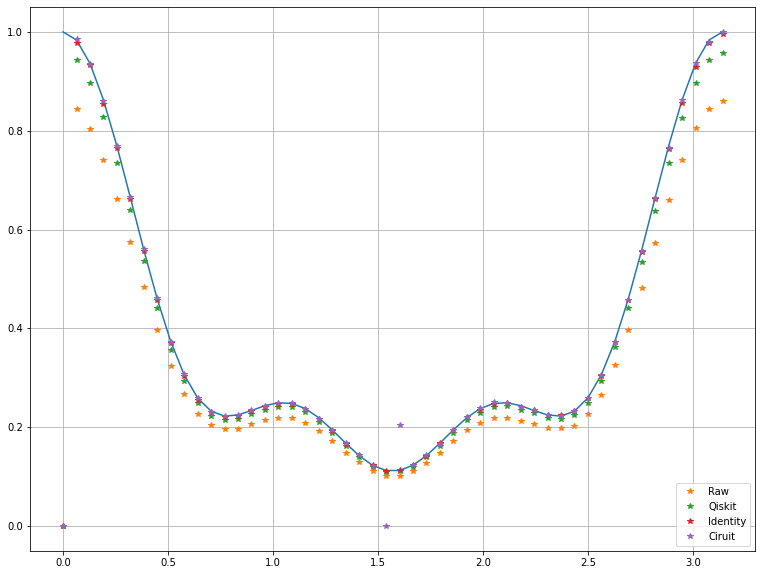

In [10]:
from qiskit.opflow import Zero, One, I, X, Y, Z

def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

ts = t_range

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]


t=t_range
plt.figure(figsize=(13,10))

plt.plot(ts, probs_110)
plt.plot(t,np.abs(F_raw),linestyle='',marker='*',label='Raw')
plt.plot(t,np.abs(F_Qiskit),linestyle='',marker='*',label='Qiskit')
plt.plot(t,np.abs(F_Identity),linestyle='',marker='*',label='Identity')
plt.plot(t,F_circuit,linestyle='',marker='*',label='Ciruit')
plt.legend()
plt.grid()
plt.show()

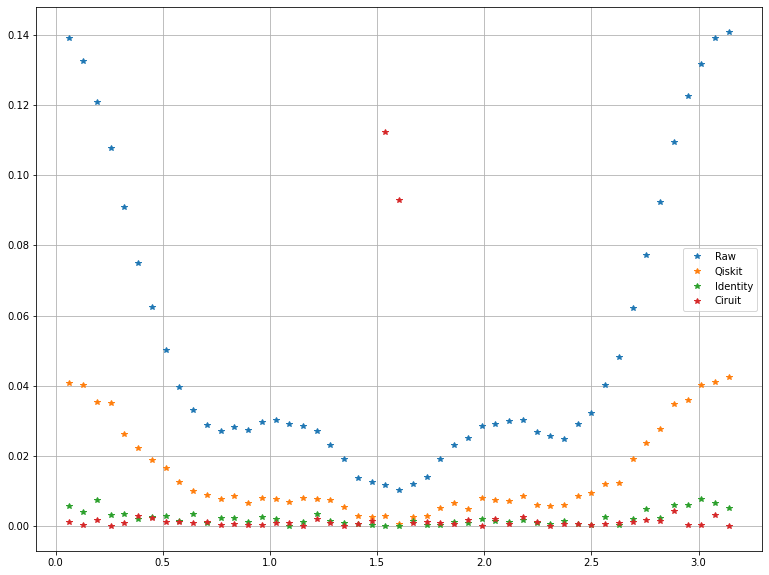

In [11]:
plt.figure(figsize=(13,10))

#plt.plot(ts, probs_110)
plt.plot(t[1:],np.abs(probs_110[1:]-F_raw[1:]),linestyle='',marker='*',label='Raw')
plt.plot(t[1:],np.abs(probs_110[1:]-F_Qiskit[1:]),linestyle='',marker='*',label='Qiskit')
plt.plot(t[1:],np.abs(probs_110[1:]-F_Identity[1:]),linestyle='',marker='*',label='Identity')
plt.plot(t[1:],np.abs(probs_110[1:]-F_circuit[1:]),linestyle='',marker='*',label='Ciruit')
plt.legend()
plt.grid()
plt.show()